### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [10]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

# from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import TavilySearchResults

from langchain_groq import ChatGroq
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [5]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [6]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [7]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [8]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [3]:
tavily = TavilySearchResults()
tavily.invoke("Provide me the recent AI news for 25 June 2025")

/var/folders/0r/vjph02mj11n18w0qm1wh0zfr0000gn/T/ipykernel_4141/2750730848.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


[{'title': '50 NEW Artificial Intelligence Statistics (June 2025) - Exploding Topics',
  'url': 'https://explodingtopics.com/blog/ai-statistics',
  'content': "Google Assistant outranks its voice assistant competitors, such as Apple's Siri and Microsoft's Cortana, with an accuracy record of **98%** in navigation.\n\n|  |  |  |  |\n| --- | --- | --- | --- |\n| Type of question | Google Assistant | Siri | Alexa |\n| Local | 93% | 89% | 85% |\n| Commerce | 92% | 68% | 71% |\n| Navigation | 98% | 86% | 72% |\n| Information | 96% | 76% | 93% |\n| Command | 86% | 93% | 69% |\n\n93%\n\n89%\n\n85%\n\n92%\n\n68%\n\n71%\n\n98%\n\n86%\n\n72%\n\n96%\n\n76%\n\n93%\n\n86%\n\n93%\n\n69% [...] | Increasing customer loyalty | 20% | 40% | ↑ 20% |\n| Increasing long-term customer engagement | 19% | 44% | ↑ 25% |\n| Building brand awareness | 14% | 31% | ↑ 17% |\n| Other | 15% | 1% | ↓ 14% | [...] #### **Recent data indicates a substantial acceleration in the adoption of AI-powered applications ([Gartner]

In [11]:
llm = ChatGroq(model="qwen-qwq-32b")

tools = [arxiv, wiki, tavily]

llm_with_tools = llm.bind_tools(tools)

In [12]:

llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to find the most up-to-date information. Let me check which tools are available. There\'s arxiv for academic papers, Wikipedia for general info, and Tavily\'s search results. Since they want recent news, Tavily\'s search results would be best because it can provide current articles. I\'ll use that. The function name is tavily_search_results_json, and the query should be "recent AI news". Let me format the tool call correctly.\n', 'tool_calls': [{'id': 'jkrr10ykp', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 268, 'total_tokens': 402, 'completion_time': 0.329564848, 'prompt_time': 0.015548811, 'queue_time': 0.070156024, 'total_time': 0.345113659}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_98b01f25b2', 'finish_re

In [13]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'qswd8k29k',
  'type': 'tool_call'}]

In [15]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

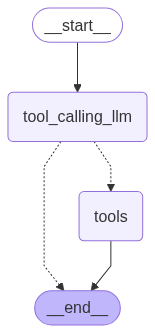

In [16]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
messages = graph.invoke({"messages": HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (kx7aq4czn)
 Call ID: kx7aq4czn
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [18]:
messages = graph.invoke({"messages": HumanMessage(content="Provide me the top 10 recent AI news for 25th June 2025 -- in short bullet points")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for 25th June 2025 -- in short bullet points
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (kyzehn0mt)
 Call ID: kyzehn0mt
  Args:
    query: Top 10 recent AI news articles from June 25, 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI Daily by Techsutra — June 25, 2025 | by TechNaut - Medium", "url": "https://medium.com/techsutra/ai-daily-by-techsutra-june-25-2025-59df323db21e", "content": "**📘 Progress Semaphore Upgrades Enterprise AI**  \n New release includes model builders, semantic knowledge graphs, and AI-ready compliance tools.  \n 📎 Source: globenewswire.com/news-release/2025/06/25/3105115\n\n**📊 Ontario’s $187B AI Wake-Up Call**  \n The Ontario Chamber of Commerce + Microsoft urge urgent action to ad

In [34]:
import json
from IPython.display import display, Markdown

news = json.loads(m.content)
news = "\n".join(n['content'] for n in news)
news = news.split("## [Latest](#stream-panel)")[0]
display(Markdown(news))

**📘 Progress Semaphore Upgrades Enterprise AI**  
 New release includes model builders, semantic knowledge graphs, and AI-ready compliance tools.  
 📎 Source: globenewswire.com/news-release/2025/06/25/3105115

**📊 Ontario’s $187B AI Wake-Up Call**  
 The Ontario Chamber of Commerce + Microsoft urge urgent action to adopt AI or risk losing billions in future GDP.  
 📎 Source: occ.ca/mediareleases/future-proofing-ontario-seizing-ais-economic-potential [...] **🛍️ BigCommerce x Feedonomics x Perplexity**  
 A major AI e-commerce alliance promises smarter, more relevant product discovery.  
 📎 Source: opentools.ai/news

**🧠 Johnson & Johnson MedTech’s AI Surgery Fund**  
 Launching the **Polyphonic™ AI Fund**, in collaboration with AWS and NVIDIA, to power the next wave of surgical AI innovation.  
 📎 Source: jnj.com/media-center/press-releases/johnson-johnson-launches-thepolyphonictm-ai-fund-for-surgery-to-advance-data-driven-healthcare [...] **🍏 Apple May Acquire Perplexity AI**  
 The tech giant is exploring a strategic acquisition of Perplexity to boost Siri and on-device intelligence.  
 📎 Source: opentools.ai/news

**🌐 Perplexity Expands Comet + Launches WhatsApp Tasking**  
 Comet browser arrives on Windows. Also: new integration lets you schedule tasks directly in WhatsApp.  
 📎 Source: opentools.ai/news


In [36]:
messages = graph.invoke({"messages": HumanMessage(content="What is Machine Learning?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (zmegq7e8h)
 Call ID: zmegq7e8h
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
